<h1><center style="color:white;background:blue;border-radius:0px 25px;padding:25px">Loan data</center></h1>

<ol>
    <li><a href="#readdata">Read data</a></li>
    <li><a href="#clean">data cleaning</a></li>
    <li><a href="#eda">EDA</a></li>
    <li><a href="#dataprep">Data Preprocessing</a></li>
    <li><a href="#model">Machine Learning Model</a></li>
    <li><a href="#tune">Hyperparameter tuning</a></li>
</ol>

## Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

import joblib

import warnings
warnings.filterwarnings('ignore')

<h1><center id="readdata" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Read data</center></h1>

In [3]:
df = pd.read_csv('data.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


- There are missing values

<h1><center id="clean" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Data Cleaning</center></h1>

In [5]:
len(df) == len(df['Loan_ID'].unique())

True

In [6]:
df.drop('Loan_ID', axis=1, inplace=True)

## Missing values

In [7]:
df.isna().sum() / len(df) * 100

Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

### drop null values

In [8]:
df.dropna(subset=['Gender', 'Married', 'Dependents', 'Self_Employed', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'], axis=0, inplace=True)

In [9]:
# reset index
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             480 non-null    object 
 1   Married            480 non-null    object 
 2   Dependents         480 non-null    object 
 3   Education          480 non-null    object 
 4   Self_Employed      480 non-null    object 
 5   ApplicantIncome    480 non-null    int64  
 6   CoapplicantIncome  480 non-null    float64
 7   LoanAmount         480 non-null    float64
 8   Loan_Amount_Term   480 non-null    float64
 9   Credit_History     480 non-null    float64
 10  Property_Area      480 non-null    object 
 11  Loan_Status        480 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 45.1+ KB


In [11]:
df['Dependents'].unique()

array(['1', '0', '2', '3+'], dtype=object)

In [12]:
df['Dependents'] = df['Dependents'].apply(lambda x : int(x.split('+')[0]))

In [13]:
df.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.777083,5364.231250,1581.093583,144.735417,342.050000,0.854167
std,1.020815,5668.251251,2617.692267,80.508164,65.212401,0.353307
min,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000
25%,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000
50%,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000
75%,2.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000
max,3.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000


## Outliers

<AxesSubplot:>

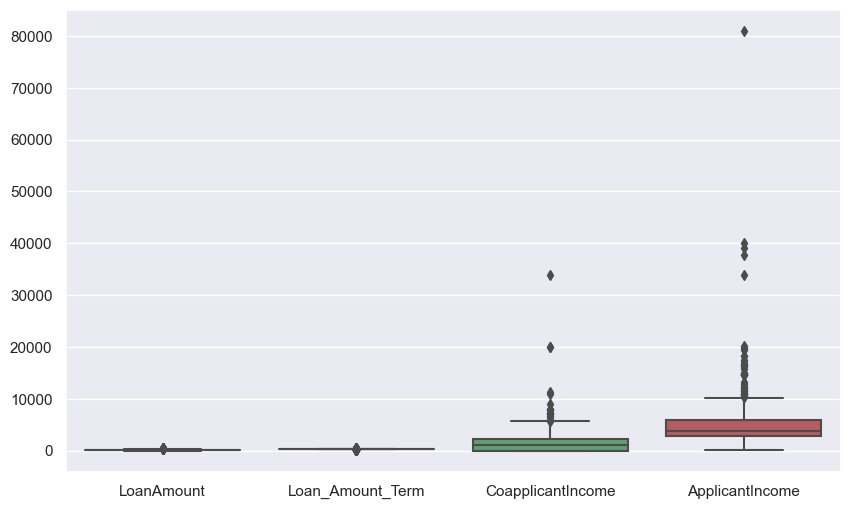

In [14]:
sns.boxplot(data=df[['LoanAmount', 'Loan_Amount_Term', 'CoapplicantIncome', 'ApplicantIncome']])

In [15]:
df[df['ApplicantIncome'] > 30000]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
120,Male,Yes,3,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y
142,Male,Yes,1,Graduate,No,33846,0.0,260.0,360.0,1.0,Semiurban,N
144,Male,Yes,0,Graduate,Yes,39147,4750.0,120.0,360.0,1.0,Semiurban,Y
319,Male,Yes,3,Graduate,No,81000,0.0,360.0,360.0,0.0,Rural,N
347,Male,No,1,Graduate,No,37719,0.0,152.0,360.0,1.0,Semiurban,Y


In [16]:
index = df[df['ApplicantIncome'] > 30000].index
df.drop(axis=0, index=index, inplace=True)

In [17]:
df[df['CoapplicantIncome'] > 10000]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
8,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N
137,Male,Yes,3,Graduate,No,5516,11300.0,495.0,360.0,0.0,Semiurban,N
312,Male,No,0,Graduate,No,2500,20000.0,103.0,360.0,1.0,Semiurban,Y
326,Male,Yes,2,Graduate,Yes,1600,20000.0,239.0,360.0,1.0,Urban,N
454,Male,No,0,Graduate,No,1836,33837.0,90.0,360.0,1.0,Urban,N


In [18]:
index = df[df['CoapplicantIncome'] > 10000].index
df.drop(axis=0, index=index, inplace=True)

<AxesSubplot:>

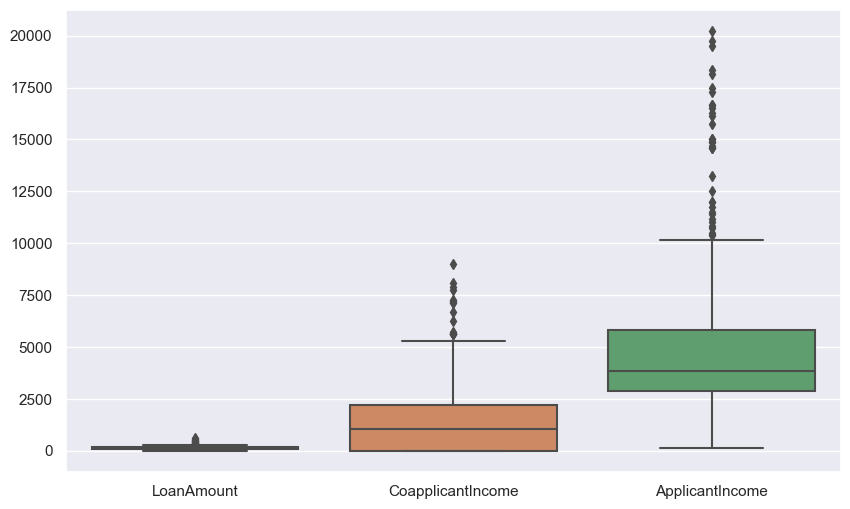

In [19]:
sns.boxplot(data=df[['LoanAmount', 'CoapplicantIncome', 'ApplicantIncome']])

In [20]:
# reset index
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

## Check duplicate values

In [21]:
duplicated = df[df.duplicated(keep='first', subset=list(df.columns))]
len(duplicated)

0

<h1><center id="eda" style="color:white;background:blue;border-radius:25px 0px;padding:25px">EDA</center></h1>

In [22]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


## Univariate Analysis

In [23]:
def subplots(x,y):
    fig, axis = plt.subplots(x, y, figsize=(20,10))
    fig.tight_layout() # to fit
    return axis

In [24]:
def get_count_precent(ax):
  for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()-0., height, '{:1.1f}%'.format((height/len(df))*100), ha="center", fontsize=15)

In [25]:
def count_plot_with_hue(features, df, hue):
  axis = subplots(3, 3)
  index = 0
  for i in range(3):
      for j in range(3):
        if index == len(features):
          break
        ax = sns.countplot(ax=axis[i][j],x=features[index],data=df, hue=hue)
        get_count_precent(ax)
        index += 1

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


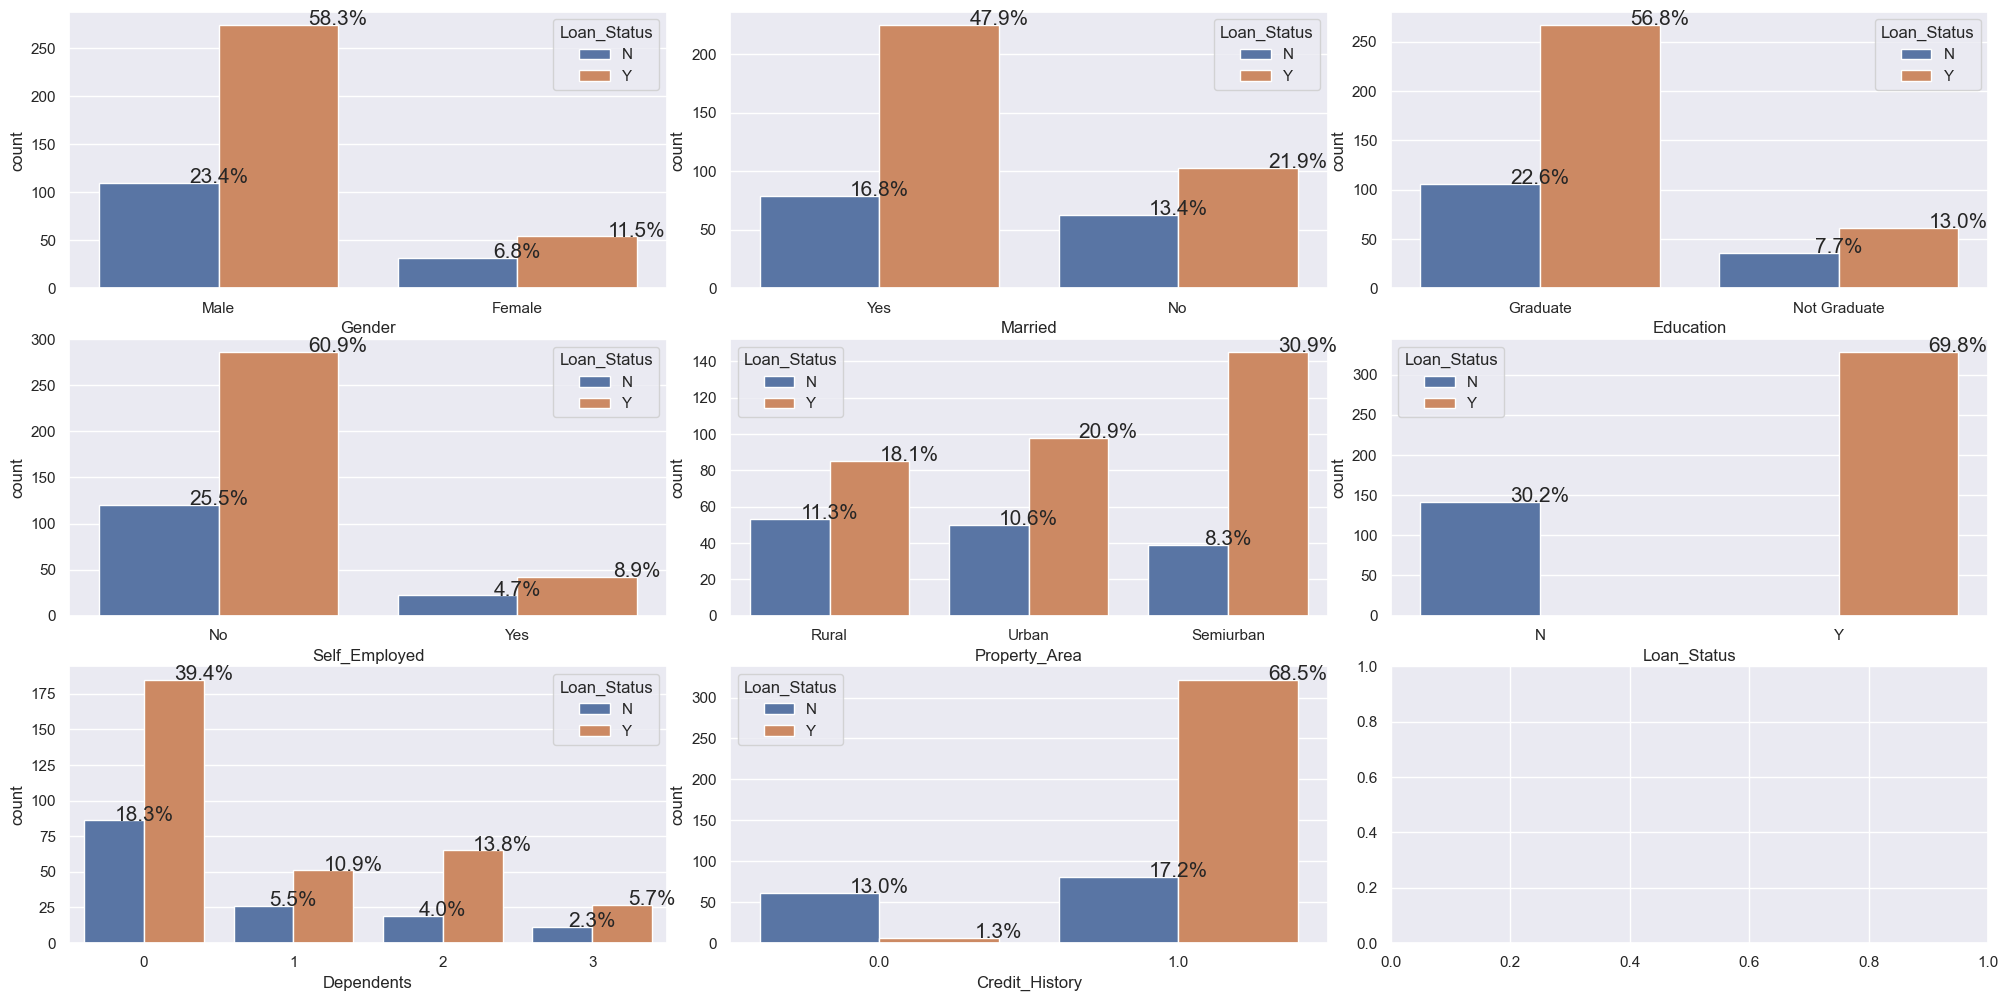

In [26]:
categorical_features = list(df.select_dtypes(include='object').columns) + ['Dependents', 'Credit_History']
count_plot_with_hue(categorical_features, df, 'Loan_Status');

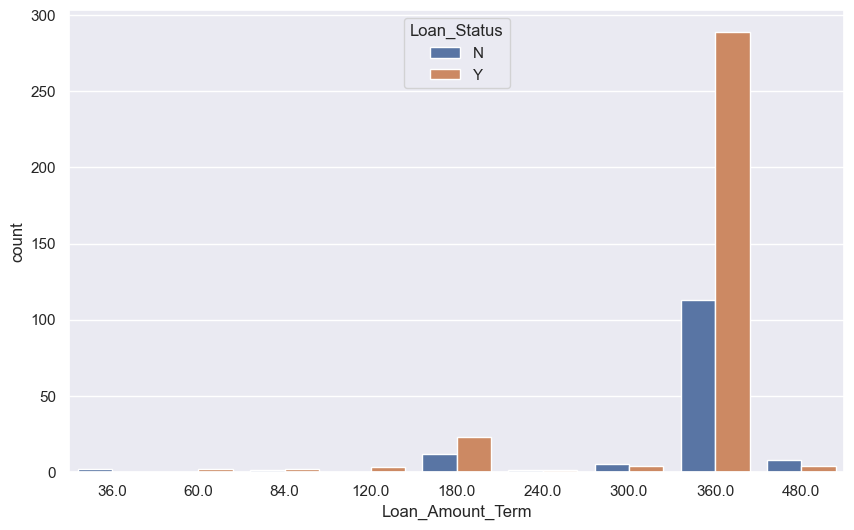

In [27]:
sns.countplot(data=df, x='Loan_Amount_Term', hue='Loan_Status');

In [28]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


## multivariate Analysis

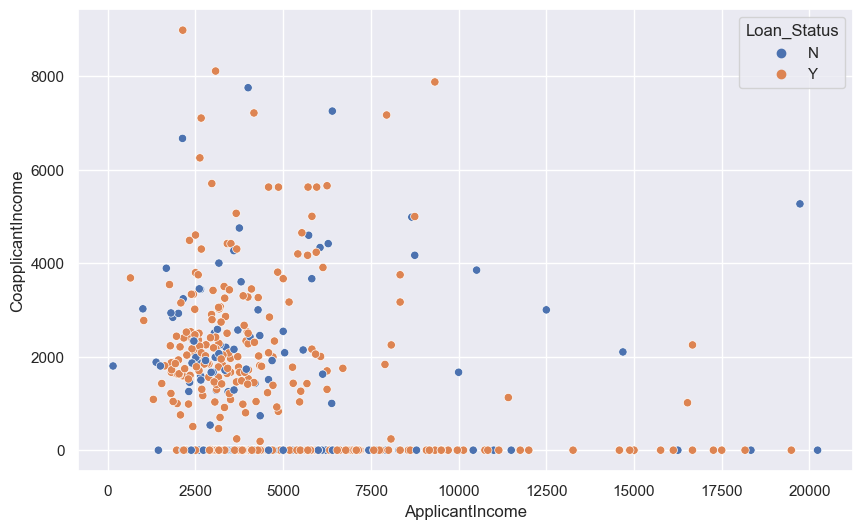

In [29]:
sns.scatterplot(data=df, x='ApplicantIncome', y='CoapplicantIncome', hue='Loan_Status');

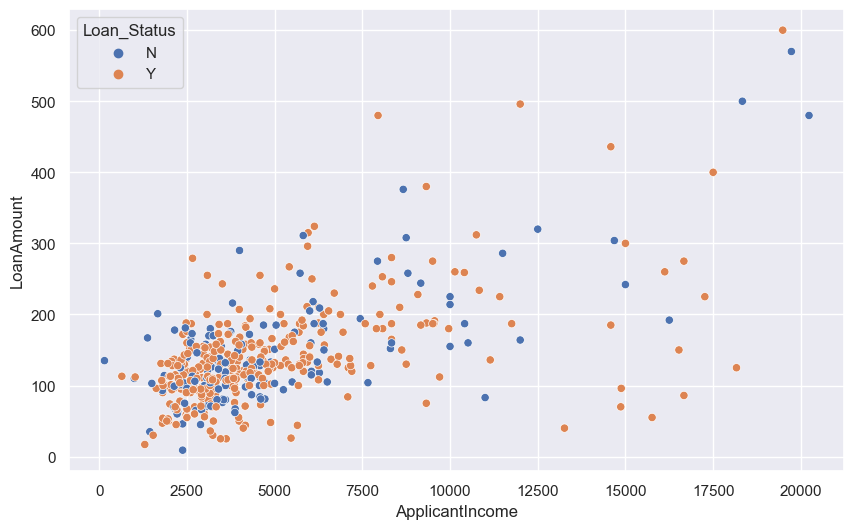

In [30]:
sns.scatterplot(data=df, x='ApplicantIncome', y='LoanAmount', hue='Loan_Status');

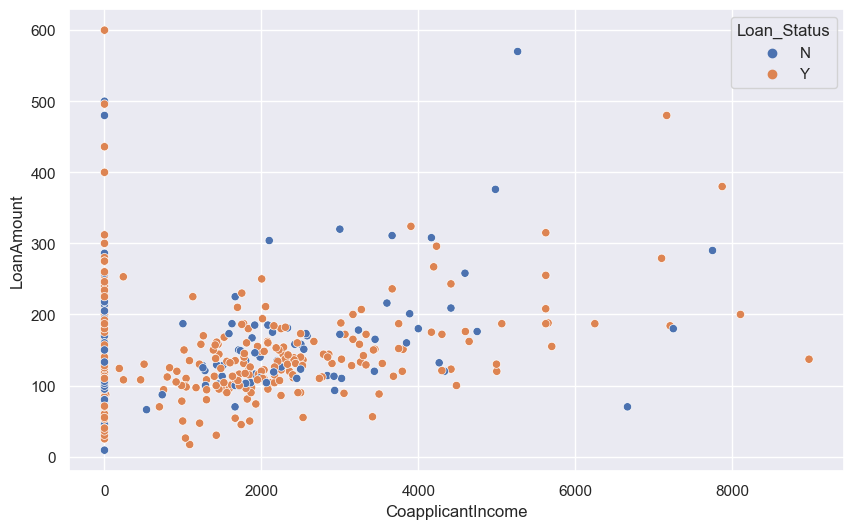

In [31]:
sns.scatterplot(data=df, x='CoapplicantIncome', y='LoanAmount', hue='Loan_Status');

<AxesSubplot:>

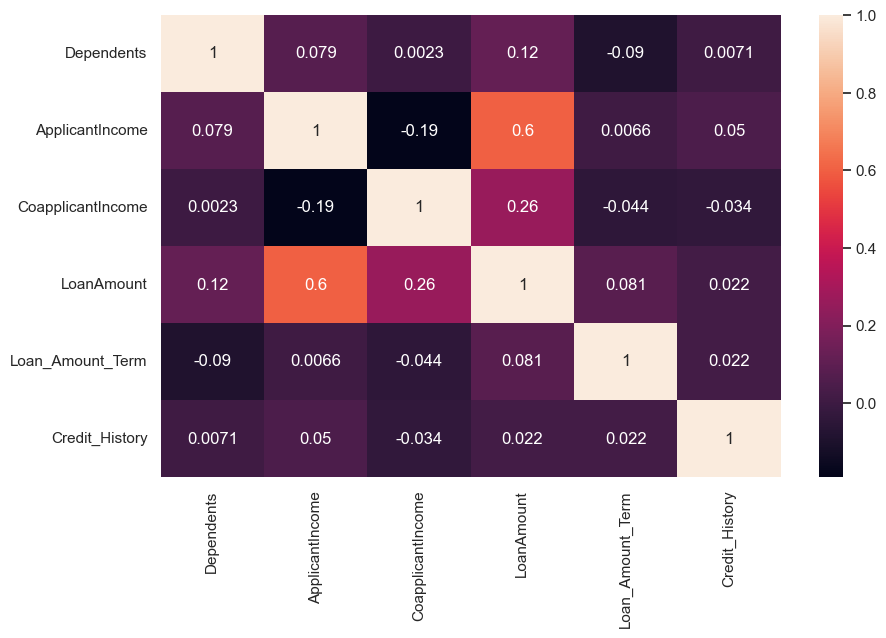

In [32]:
sns.heatmap(df.corr(), annot=True)

<h1><center id="dataprep" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Data Preprocessing</center></h1>

In [33]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [34]:
df['Loan_Status'].replace({'Y':1, 'N':0}, inplace=True)

<h1><center id="model" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Model</center></h1>

### Our data need algorithm with tree based to get high performance
- let's check DecisionTree, RandomForest, and XGBoost

## Split data

In [35]:
x = df.drop(['Loan_Status'], axis=1)
y = df['Loan_Status']

## Pipeline
- Encoder (One hot)

- Scaler (RobustScaler)

- Models

In [36]:
columns_fransformer = ColumnTransformer(
    transformers=[
        ("OHE", OneHotEncoder(sparse=False, drop="first"), ["Gender" , "Married", "Education", "Self_Employed", "Property_Area"]), 
        ("Scale", RobustScaler(), ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'])
    ],
    remainder="passthrough"
)

In [37]:
models = list()
models.append(("CART" , DecisionTreeClassifier()))
models.append(("RF" , RandomForestClassifier()))
models.append(("xg" , XGBClassifier()))
models.append(("KNN", KNeighborsClassifier()))

In [40]:
for model in models:
    steps = list()
    steps.append(("columns_fransformer" , columns_fransformer))
    steps.append(model)
    pipeline = Pipeline(steps = steps)
    scores = cross_validate(estimator=pipeline, X=x, y=y, scoring="precision", cv = 10, return_train_score=True, error_score='raise')
    print(model[0])
    print("Train_accuracy" , scores["train_score"].mean() )
    print("-" * 10)
    print("Test_accuracy" , scores["test_score"].mean())
    print("-" * 20)
    print("\n")

CART
Train_accuracy 1.0
----------
Test_accuracy 0.81816292003792
--------------------


RF
Train_accuracy 1.0
----------
Test_accuracy 0.8096238966141932
--------------------


xg
Train_accuracy 0.9996621621621621
----------
Test_accuracy 0.8201891962727876
--------------------


KNN
Train_accuracy 0.792039380787434
----------
Test_accuracy 0.7467003466391471
--------------------




<h1><center id="tune" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Hyperparameter tuning</center></h1>

In [41]:
steps = list()
steps.append(("Columns_transformer" , columns_fransformer))
steps.append(("Model", XGBClassifier()))
pipeline = Pipeline(steps=steps)

In [54]:
params = {
    "Model__booster":['gbtree', 'dart'],
    "Model__n_estimators": [50, 75, 100],
    "Model__max_depth": [4, 6, 8],
    "Model__random_state": [None, 42]
}

In [55]:
GRD_search = GridSearchCV(estimator=pipeline,param_grid=params, scoring='precision', n_jobs=-1, cv=10)

In [56]:
GRD_search.fit(x,y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Columns_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('OHE',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['Gender',
                                                                          'Married',
                                                                          'Education',
                                                                          'Self_Employed',
                                                                          'Property_Area']),
                                                                        ('Scale',
                                                                         RobustScaler(),
                                                                         ['ApplicantIncome',
                                                                          'CoapplicantIncome',
                                                                          'LoanAmount',
                                                                          'Loan_Amount_Term'])])),
                                       ('Model',
                                        XGB...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None, ...))]),
             n_jobs=-1,
             param_grid={'Model__booster': ['gbtree', 'dart'],
                         'Model__max_depth': [4, 6, 8],
                         'Model__n_estimators': [50, 75, 100],
                         'Model__random_state': [None, 42]},
             scoring='precision')

In [57]:
print("Best parameters", GRD_search.best_params_)
print("Best Score", GRD_search.best_score_)
model = GRD_search.best_estimator_

Best parameters {'Model__booster': 'gbtree', 'Model__max_depth': 6, 'Model__n_estimators': 75, 'Model__random_state': None}
Best Score 0.8241108246681002


In [58]:
train_score = model.score(x, y)
print(f'Training Accuracy: {train_score}')

Training Accuracy: 0.997872340425532


# Save $:-$
    1. Inputs
    2. Pipeline

In [44]:
# inputs
joblib.dump(x.columns, 'Inputs.h5')
# pipeline
joblib.dump(model, 'model.h5')

['model.h5']